In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import sys
root=os.getcwd()
sys.path.append(root)
sys.path.append('..')
from temp_task import RikhyeTask
from temp_model import TempNetwork



# Generate trainset
RNGSEED = 5 # set random seed
np.random.seed([RNGSEED])

Ntrain = 500            # number of training cycles for each context
Nextra = 200            # add cycles to show if block1
Ncontexts = 2           # number of cueing contexts (e.g. auditory cueing context)
inpsPerConext = 2       # in a cueing context, there are <inpsPerConext> kinds of stimuli
                         # (e.g. auditory cueing context contains high-pass noise and low-pass noise)
dataset = RikhyeTask(Ntrain=Ntrain, Nextra=Nextra, Ncontexts=Ncontexts, inpsPerConext=inpsPerConext, blockTrain=True)



# Model settings
n_neuron = 1000
n_neuron_per_cue = 200
Num_MD = 10
num_active = 5  # num MD active per context
n_output = 2
MDeffect = True
# MDeffect = False

model = TempNetwork(Num_PFC=n_neuron, n_neuron_per_cue=n_neuron_per_cue, Num_MD=Num_MD, num_active=num_active, num_output=n_output, \
MDeffect=MDeffect)



# Training
import time

criterion = nn.MSELoss()

training_params = list()
for name, param in model.named_parameters():
    print(name)
    training_params.append(param)
print('\n')
optimizer = torch.optim.Adam(training_params, lr=1e-3)


total_step = Ntrain*Ncontexts+Nextra
print_step = 10
running_loss = 0.0
running_train_time = 0
losses = []
timestamps = []
model_name = 'model-' + str(int(time.time()))
savemodel = False


for i in range(total_step):

    train_time_start = time.time()

    # extract data
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels).type(torch.float)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs, labels)
    loss = criterion(outputs, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # normalization
    optimizer.step()

    # print statistics
    running_train_time += time.time() - train_time_start
    running_loss += loss.item()

    if i % print_step == (print_step - 1):

        print('Total step: {:d}'.format(total_step))
        print('Training sample index: {:d}-{:d}'.format(i+1-print_step, i+1))

        # running loss
        print('loss: {:0.5f}'.format(running_loss / print_step))
        losses.append(running_loss / print_step)
        timestamps.append(i+1-print_step)
        running_loss = 0.0

        # training time
        print('Predicted left training time: {:0.0f} s'.format(
        (running_train_time) * (total_step - i - 1) / print_step),
        end='\n\n')
        running_train_time = 0

        if savemodel:
            # save model every print_step
            fname = os.path.join('models', model_name + '.pt')
            torch.save(model.state_dict(), fname)

            # save info of the model
            fpath = os.path.join('models', model_name + '.txt')
            with open(fpath, 'w') as f:
                f.write('input_size = ' + str(input_size) + '\n')
                f.write('hidden_size = ' + str(hidden_size) + '\n')
                f.write('output_size = ' + str(output_size) + '\n')
                f.write('num_layers = ' + str(num_layers) + '\n')


print('Finished Training')

pfc2out.weight
pfc2out.bias


Total step: 1200
Training sample index: 0-10
loss: 0.19817
Predicted left training time: 879 s

Total step: 1200
Training sample index: 10-20
loss: 0.07174
Predicted left training time: 581 s

Total step: 1200
Training sample index: 20-30
loss: 0.04248
Predicted left training time: 554 s

Total step: 1200
Training sample index: 30-40
loss: 0.02820
Predicted left training time: 521 s

Total step: 1200
Training sample index: 40-50
loss: 0.01858
Predicted left training time: 710 s

Total step: 1200
Training sample index: 50-60
loss: 0.01348
Predicted left training time: 711 s

Total step: 1200
Training sample index: 60-70
loss: 0.01034
Predicted left training time: 651 s

Total step: 1200
Training sample index: 70-80
loss: 0.00860
Predicted left training time: 656 s

Total step: 1200
Training sample index: 80-90
loss: 0.00759
Predicted left training time: 623 s

Total step: 1200
Training sample index: 90-100
loss: 0.00696
Predicted left training time: 626 s



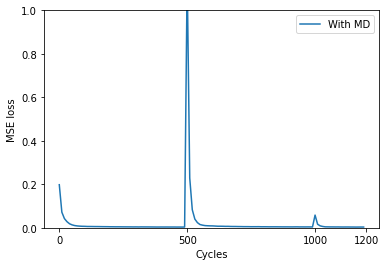

In [4]:
# Plot MSE curve
import matplotlib.pyplot as plt

plt.plot(timestamps, losses, label='With MD')
plt.xlabel('Cycles')
plt.ylabel('MSE loss')
plt.legend()
plt.xticks([0, 500, 1000, 1200])
plt.ylim([0.0, 1.0])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()